/DeepLearning/mnt/shixiansheng/data_fusion/output/BarronScript_ALL_2011_FtAIndex.csv
/DeepLearning/mnt/shixiansheng/data_fusion/output/BarronHarvard_ALL_2011_FtAIndex.csv
Directory already exists: /DeepLearning/mnt/shixiansheng/data_fusion/output/Map_2011_FtA_HarvardVsFtA_Barron's Script


/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/rsm_helper/model_property.py:76: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  self.lats, self.lons = transform(projection, 'EPSG:4326',grid_x, grid_y)


X-axis Key_Periods: ['top-10']
Y-axis Key_Periods: ['top-10']


  0%|          | 0/1 [00:00<?, ?it/s]

/DeepLearning/mnt/shixiansheng/data_fusion/output/BarronScript_ALL_2011_FtAIndex.csv
/DeepLearning/mnt/shixiansheng/data_fusion/output/BarronHarvard_ALL_2011_FtAIndex.csv


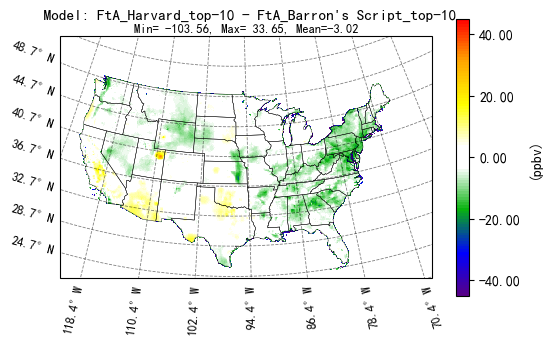

The data fusion plot for 2011 top-10 Model-Model is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/Map_2011_FtA_HarvardVsFtA_Barron's Script/2011_top-10_Model-Model_diff_data_fusion.png
Done!


In [ ]:
import os
import re
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

# for show maps
from esil.rsm_helper.model_property import model_attribute
from esil.map_helper import get_multiple_data, show_maps
import cmaps

cmap_conc = cmaps.WhiteBlueGreenYellowRed
cmap_delta = cmaps.ViBlGrWhYeOrRe


def extract_key_period(period):
    """
    Extract key period (e.g., JFM, AMJ) from the full period string.
    """
    # key_periods = ['Annual', 'Apr-Sep', 'top-10', '98th', "DJF", "MAM", "JJA", "SON","July"]  # Add more if needed
    key_periods = ["top-10"] 
    for key in key_periods:
        if key in period:
            return key
    return None


def get_prefix(filename):
    """
    Determine the prefix based on the filename.
    If the filename contains 'daily' or 'IA', return 'IA'; otherwise, return 'AI'.
    """
    print(filename)
    if "daily" in filename.lower() or "FtA" in filename:
        return "FtA"
    return "AtF"


def get_year(filename):
    """
    Extract the year from the filename (assuming the year is in the range 2011-2020).
    """
    match = re.search(r"(20[1-2][0-9])", filename)  # Match years between 2011 and 2020
    if match:
        return match.group(1)
    return None


def get_axis_label(filename, period=None, year=None):
    """
    Generate the axis label based on the filename.
    - If the filename contains 'DFT', the label is 'DFT'.
    - If the filename does not contain 'DFT', the label is 'Python'.
    - Combine with the prefix (IA or AI), period, and year to form the final label.
    """
    prefix = get_prefix(filename)
    if "DFT" in filename.upper():
        label = "DFT"
    elif "BarronResult" in filename:
        label = "Barron's Result"
    elif "BarronScript" in filename:
        label = "Barron's Script"
    elif "Python" in filename:
        label = "Python"
    elif "EQUATES" in filename:
        label = "EQUATES"
    elif "Harvard" in filename:
        label = "Harvard"
    elif"BarronHarvard" in filename:
        label = "BarronHarvard"
    else:
        label = "unkown"

    # Add period and year to the label if provided
    if period and year:
        return f"{prefix}_{label}_{period}"
    elif period:
        return f"{prefix}_{label}_{period}"
    elif year:
        return f"{prefix}_{label}_{year}"
    return f"{prefix}_{label}"


def simplify_variable_name(variable):
    """
    Simplify variable names: vna_ozone -> vna
    """
    if variable == 'vna_ozone':
        return 'VNA'
    if variable == 'evna_ozone':
        return 'eVNA'
    if variable == 'avna_ozone':
        return 'aVNA'
    if variable == 'ds_ozone':
        return 'DS' 
    if variable == 'model':
        return 'Model'
    return variable



def plot_us_map(
    fusion_output_file_x,
    fusion_output_file_y,
    model_file,
    save_path=None,
    boundary_json_file="/DeepLearning/mnt/Devin/boundary/USA_State.json",
    comparisons=None,
    variable_settings=None
):
    """
    description: plot the US map with different data fusion results
    @param {string} fusion_output_file_x: the data fusion output file for the x-axis
    @param {string} fusion_output_file_y: the data fusion output file for the y-axis
    @param {string} model_file: the model file used for data fusion
    @param {string} save_path: the path to save the plot
    @param {string} boundary_json_file: the boundary file for the US map
    @param {list} comparisons: list of tuples, each tuple contains two variable names for comparison
    @param {dict} variable_settings: dictionary of settings for each comparison
    @return None
    """
    # Load model attributes
    mp = model_attribute(model_file)
    proj, longitudes, latitudes = mp.projection, mp.lons, mp.lats

    # Read both x-axis and y-axis data
    df_data_x = pd.read_csv(fusion_output_file_x)
    df_data_y = pd.read_csv(fusion_output_file_y)

    # Check if the required columns exist
    if "Period" not in df_data_x.columns or "Period" not in df_data_y.columns:
        print("The data fusion files do not contain the Period column!")
        return

    # Extract key periods (e.g., JFM, AMJ) from the Period column
    df_data_x["Key_Period"] = df_data_x["Period"].apply(extract_key_period)
    df_data_y["Key_Period"] = df_data_y["Period"].apply(extract_key_period)

    # Drop rows where Key_Period is None
    df_data_x = df_data_x.dropna(subset=["Key_Period"])
    df_data_y = df_data_y.dropna(subset=["Key_Period"])

    # Debug: Print unique Key_Periods
    print("X-axis Key_Periods:", df_data_x["Key_Period"].unique())
    print("Y-axis Key_Periods:", df_data_y["Key_Period"].unique())

    # Extract year from filenames
    year_x = get_year(fusion_output_file_x)
    year_y = get_year(fusion_output_file_y)

    if year_x != year_y:
        print("Warning: The years in the input files do not match!")
        return

    year = year_x  # Use the year from the x-axis file (assuming they match)

    # Process each key period
    key_periods = df_data_x["Key_Period"].unique()
    for key_period in tqdm(key_periods):
        # Filter data for the current key period
        df_x_period = df_data_x[df_data_x["Key_Period"] == key_period]
        df_y_period = df_data_y[df_data_y["Key_Period"] == key_period]

        if len(df_x_period) == 0 or len(df_y_period) == 0:
            print(f"No data found for period {key_period} in one of the files!")
            continue

        for variable_x, variable_y in comparisons:
            if variable_x not in df_x_period.columns or variable_y not in df_y_period.columns:
                print(f"Variable {variable_x} or {variable_y} not found in data files. Skipping...")
                continue

            # Generate axis labels with period and year information
            x_label = get_axis_label(fusion_output_file_x, key_period, year)  # e.g., AI_DFT_JFM_2011
            y_label = get_axis_label(fusion_output_file_y, key_period, year)  # e.g., IA_Python_JFM_2011

            # Simplify variable names
            simple_variable_x = simplify_variable_name(variable_x)
            simple_variable_y = simplify_variable_name(variable_y)

            # Reshape data to match the grid
            grid_variable_x = df_x_period[variable_x].values.reshape(longitudes.shape)
            grid_variable_y = df_y_period[variable_y].values.reshape(longitudes.shape)

            # Calculate differences (y - x)
            grid_variable_diff = grid_variable_y - grid_variable_x

            # Get settings for the current comparison
            comparison_key = f"{simple_variable_y}-{simple_variable_x}"
            settings = variable_settings.get(comparison_key, {})

            # Prepare data for plotting
            dict_data = {}
            get_multiple_data(
                dict_data,
                # dataset_name=comparison_key,
                dataset_name='',
                # variable_name=f"{y_label}_{simple_variable_y} - {x_label}_{simple_variable_x}", 
                #also same
                variable_name=f"{simple_variable_y}: {y_label} - {x_label}", # y - x
                grid_x=longitudes,
                grid_y=latitudes,
                grid_concentration=grid_variable_diff,
                is_delta=settings.get('is_delta', True),
                cmap=settings.get('cmap_delta', cmap_delta)
            )

            # Plot the maps
            fig = show_maps(
                dict_data,
                unit=settings.get('unit', "ppbv"),
                cmap=settings.get('cmap_conc', cmap_conc),
                show_lonlat=settings.get('show_lonlat', True),
                projection=proj,
                is_wrf_out_data=settings.get('is_wrf_out_data', True),
                boundary_file=boundary_json_file,
                show_original_grid=settings.get('show_original_grid', True),
                panel_layout=settings.get('panel_layout', None),  # Automatically determine layout
                delta_map_settings=settings.get('delta_map_settings', {
                    "cmap": cmap_delta,
                    "value_range": (None, None),  # Let the function auto-scale
                    "colorbar_ticks_num": None,
                    "colorbar_ticks_value_format": ".2f",
                    "value_format": ".2f",
                }),
                title_fontsize=settings.get('title_fontsize', 11),
                xy_title_fontsize=settings.get('xy_title_fontsize', 9),
                show_dependenct_colorbar=settings.get('show_dependenct_colorbar', True),
                show_domain_mean=settings.get('show_domain_mean', True)
            )

            # Save the plot with year, period, and variable prefix
            if save_path is not None:
                save_file = os.path.join(save_path, f"{year}_{key_period}_{comparison_key}_diff_data_fusion.png")
                fig.savefig(save_file, dpi=300, bbox_inches="tight")
                print(f"The data fusion plot for {year} {key_period} {comparison_key} is saved to {save_file}")


if __name__ == "__main__":
    # 定义基础保存路径
    base_save_path = r"/DeepLearning/mnt/shixiansheng/data_fusion/output"

    # 输入文件
    # IA and Python refers to y
    fusion_output_file_y = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/BarronHarvard_ALL_2011_FtAIndex.csv"
    # fusion_output_file_y = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/2011_daily_DF_seasonal_O3-MDA8.csv"
    # fusion_output_file_y = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/seasonal_fused_data_2011_AnnualApr.csv"
    fusion_output_file_x = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/BarronScript_ALL_2011_FtAIndex.csv"

    # 生成轴标签
    x_label = get_axis_label(fusion_output_file_x)  # 例如：AI_DFT
    y_label = get_axis_label(fusion_output_file_y)  # 例如：IA_Python

    # 提取年份
    year = get_year(fusion_output_file_x)  # 例如：2011

    # 动态生成路径名称
    save_path = os.path.join(base_save_path, f"Map_{year}_{y_label}Vs{x_label}")

    # 如果路径不存在，则自动创建
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        print(f"Created directory: {save_path}")
    else:
        print(f"Directory already exists: {save_path}")

    # 其他代码
    model_file = r"/backupdata/data_EPA/EQUATES/EQUATES_data/HR2DAY_LST_ACONC_v532_cb6r3_ae7_aq_WR413_MYR_STAGE_2011_12US1_2011.nc"

    # 指定要进行的对比
    # comparisons = [('vna_ozone', 'vna_ozone'),('evna_ozone','evna_ozone'),('avna_ozone','avna_ozone')]
    comparisons = [('model','model')]

    # 为每个对比设置独立的绘图参数
    # 这里需要更新 variable_settings 的键名，使用简化后的变量名
    variable_settings = { 
        'evna-evna': {
            'is_delta': True,
            'cmap_delta': cmaps.ViBlGrWhYeOrRe,
            'unit': "ppbv",
            'cmap_conc': cmaps.WhiteBlueGreenYellowRed,
            'show_lonlat': True,
            'is_wrf_out_data': True,
            'show_original_grid': True,
            'panel_layout': None,
            'delta_map_settings': {
                "cmap": cmaps.ViBlGrWhYeOrRe,
                "value_range": (-8, 8),
                "colorbar_ticks_num": None,
                "colorbar_ticks_value_format": ".2f",
                "value_format": ".2f"
            },
            'title_fontsize': 11,
            'xy_title_fontsize': 9,
            'show_dependenct_colorbar': True,
            'show_domain_mean': True
        },
        'avna-avna': {
            'is_delta': True,
            'cmap_delta': cmaps.ViBlGrWhYeOrRe,
            'unit': "ppbv",
            'cmap_conc': cmaps.WhiteBlueGreenYellowRed,
            'show_lonlat': True,
            'is_wrf_out_data': True,
            'show_original_grid': True,
            'panel_layout': None,
            'delta_map_settings': {
                "cmap": cmaps.ViBlGrWhYeOrRe,
                "value_range":  (-8,8),
                "colorbar_ticks_num": None,
                "colorbar_ticks_value_format": ".2f",
                "value_format": ".2f"
            },
            'title_fontsize': 11,
            'xy_title_fontsize': 9,
            'show_dependenct_colorbar': True,
            'show_domain_mean': True
        },
        'vna-vna': {
            'is_delta': True,
            'cmap_delta': cmaps.ViBlGrWhYeOrRe,
            'unit': "ppbv",
            'cmap_conc': cmaps.WhiteBlueGreenYellowRed,
            'show_lonlat': True,
            'is_wrf_out_data': True,
            'show_original_grid': True,
            'panel_layout': None,
            'delta_map_settings': {
                "cmap": cmaps.ViBlGrWhYeOrRe,
                "value_range":  (-8,8),
                "colorbar_ticks_num": None,
                "colorbar_ticks_value_format": ".2f",
                "value_format": ".2f"
            },
            'title_fontsize': 11,
            'xy_title_fontsize': 9,
            'show_dependenct_colorbar': True,
            'show_domain_mean': True
        },
        'model-model': {
            'is_delta': True,
            'cmap_delta': cmaps.ViBlGrWhYeOrRe,
            'unit': "ppbv",
            'cmap_conc': cmaps.WhiteBlueGreenYellowRed,
            'show_lonlat': True,
            'is_wrf_out_data': True,
            'show_original_grid': True,
            'panel_layout': None,
            'delta_map_settings': {
                "cmap": cmaps.ViBlGrWhYeOrRe,
                "value_range":  (-1, -1),
                "colorbar_ticks_num": None,
                "colorbar_ticks_value_format": ".2f",
                "value_format": ".2f"
            },
            'title_fontsize': 11,
            'xy_title_fontsize': 9,
            'show_dependenct_colorbar': True,
            'show_domain_mean': True
        },
        'ds-ds': {
            'is_delta': True,
            'cmap_delta': cmaps.ViBlGrWhYeOrRe,
            'unit': "ppbv",
            'cmap_conc': cmaps.WhiteBlueGreenYellowRed,
            'show_lonlat': True,
            'is_wrf_out_data': True,
            'show_original_grid': True,
            'panel_layout': None,
            'delta_map_settings': {
                "cmap": cmaps.ViBlGrWhYeOrRe,
                "value_range": (-31, 31),
                "colorbar_ticks_num": None,
                "colorbar_ticks_value_format": ".2f",
                "value_format": ".2f"
            },
            'title_fontsize': 11,
            'xy_title_fontsize': 9,
            'show_dependenct_colorbar': True,
            'show_domain_mean': True
        }
    }

    plot_us_map(
        fusion_output_file_x,
        fusion_output_file_y,
        model_file,
        save_path,
        comparisons=comparisons,
        variable_settings=variable_settings
    )
    print("Done!")